In [ ]:
!pip install wordcloud==1.8.1

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# STOP WORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer

import string
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

english_punctuations = string.punctuation
punctuations_list = english_punctuations

#remove stopwords 
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Read and Load the Dataset

In [ ]:
df = pd.read_csv('/work/EmotionAnalysis/tweet_emotions.csv')
#display(df)

## Data Analysis

In [ ]:
df.columns

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

In [ ]:
# null value check
np.sum(df.isnull().any(axis=1))

0

In [ ]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   3
Count of rows in the data is:   40000


# Data Visualization

[Text(0, 0, 'empty'),
 Text(1, 0, 'sadness'),
 Text(2, 0, 'enthusiasm'),
 Text(3, 0, 'neutral'),
 Text(4, 0, 'worry'),
 Text(5, 0, 'surprise'),
 Text(6, 0, 'love'),
 Text(7, 0, 'fun'),
 Text(8, 0, 'hate'),
 Text(9, 0, 'happiness'),
 Text(10, 0, 'boredom'),
 Text(11, 0, 'relief'),
 Text(12, 0, 'anger')]

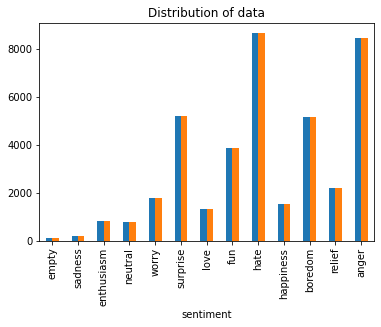

In [ ]:
# Plotting the distribution for dataset.
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(df['sentiment'].unique(), rotation=90)

# Data Preprocessing&nbsp;

In [ ]:
# data qu'on veut analyser
data_preprocessed = df[['content','sentiment']]
data_preprocessed = data_preprocessed[data_preprocessed.sentiment != "empty"]

In [ ]:
def cleaning_tweet(text):
    # removing punctuation
    translator = str.maketrans('', '', punctuations_list)
    text = text.translate(translator)

    # removing stop words 
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])

    # removing pseudos
    text = text.replace('@[a-zA-Z0-9-_]*',"")

    # to lower case
    text = text.lower()

    # remove URL
    text = text.replace('((www.[^s]+)|(https?://[^s]+))',"")

    return text

In [ ]:
# remove stop word
data_preprocessed['content'] = data_preprocessed['content'].apply(lambda text: cleaning_tweet(text))

#tokenization
tokenizer = RegexpTokenizer(r'\w+|$[0-9]+|\S+')
data_preprocessed['content'] = data_preprocessed['content'].apply(
    lambda x: tokenizer.tokenize(x)
)

In [ ]:
# replace sentiment with numbers
sentiment_to_number = {
    'boredom' : 4,
    'sadness': 3 ,
    'worry' : 2,
    'hate' : 1,
    'anger' : 0,
    'neutral' : 5,
    'enthusiasm' : 7,
    'surprise' : 8,
    'love' : 9,
    'fun' : 7,
    'happiness' : 7,    
    'relief' : 6
}

data_preprocessed['sentiment'] = data_preprocessed['sentiment'].replace(to_replace = sentiment_to_number)

In [ ]:
display(data_preprocessed)

,content,sentiment
1,"[layin, n, bed, headache, ughhhhwaitin, call]",3
2,"[funeral, ceremonygloomy, friday]",3
3,"[wants, hang, friends, soon]",7
4,"[dannycastillo, we, want, trade, someone, hous...",5
5,"[repinging, ghostridah14, didnt, go, prom, bc,...",2
...,...,...
39995,[johnlloydtaylor],5
39996,"[happy, mothers, day, all, love]",9
39997,"[happy, mothers, day, mommies, woman, man, lon...",9
39998,"[niariley, wassup, beautiful, follow, me, peep...",7


In [ ]:
_deepnote_run_altair(data_preprocessed, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"bar","tooltip":true},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"sentiment","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"COUNT(*)","type":"quantitative","sort":null,"aggregate":"count","scale":{"type":"linear","zero":true}},"color":{"field":"","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [ ]:
# input feature (X) = content and label (Y) = sentiment
X = data_preprocessed['content'].astype(str)
y = data_preprocessed['sentiment']

## Train and Test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =3455)

In [ ]:
print (X_test)

30076    ['salioelsol08', 'haha', 'def', 'rob', 'bank',...
6070     ['playing', 'guitar', 'hero', 'let', 'steam', ...
3512                       ['accounts', 'revision', 'boo']
13459    ['answering', 'detailed', 'questions', 'via', ...
1276     ['watching', 'jay', 'lenos', '2nd', 'last', 't...
                               ...                        
25875    ['sotwitterpated', 'hi', 'yeah', 'im', 'fine',...
7096     ['autisminsights', 'laundry', 'instead', 'sitt...
32992                               ['dollg1974', 'thank']
18990                 ['nursing', 'sore', 'back', 'today']
2778     ['weather', 'may', 'makes', 'cause', 'temp', '...
Name: content, Length: 1959, dtype: object


## TF-IDF Vectorizer

In [ ]:
vectorizer= TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

No. of feature_words:  244668
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## MODEL BUILDING

In [ ]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    return y_pred

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
    labels = unique_labels(y_test)
    column = [f'Predicted {label}' for label in labels]
    indices = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = column, index = indices)

    plt.figure(figsize=(10,10))
    sns.heatmap(table, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

### Bernouilli

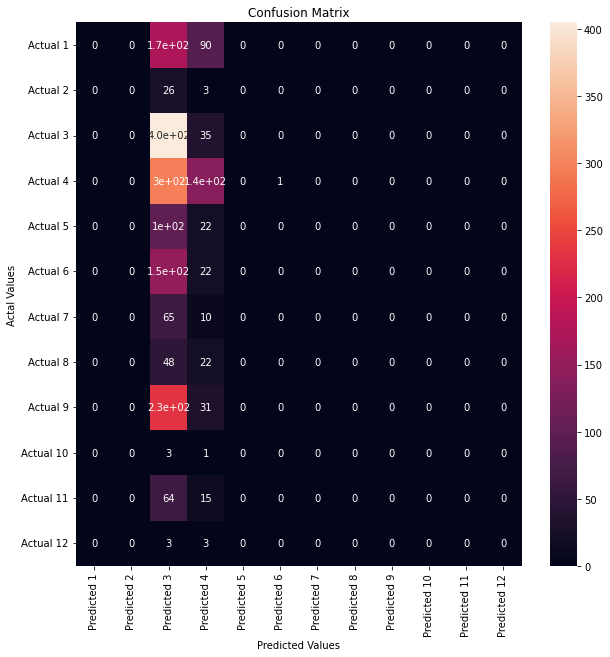

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred1 = model_Evaluate(BNBmodel)

# confusion matrix 
plot_confusion_matrix(y_test, y_pred1)

### SVM

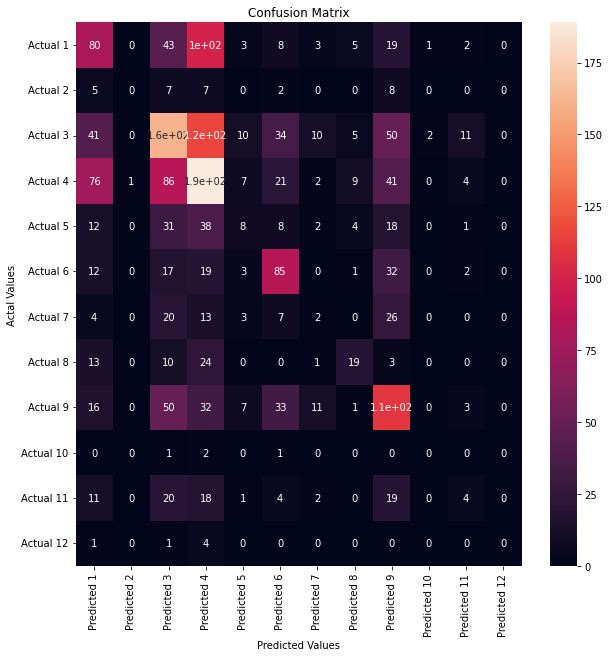

None

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

# confusion matrix 
display(plot_confusion_matrix(y_test, y_pred2))

### Logistic Regression

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)


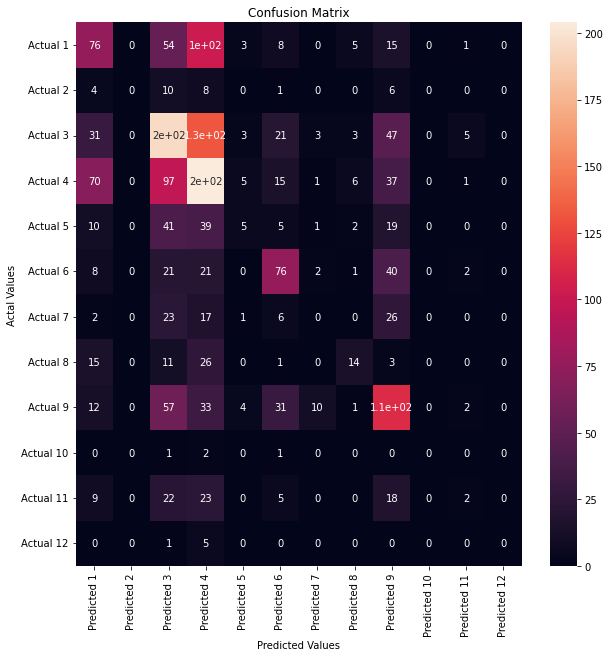

None

In [ ]:
# confusion matrix 
plot_confusion_matrix(y_test, y_pred3)

# Word cloud

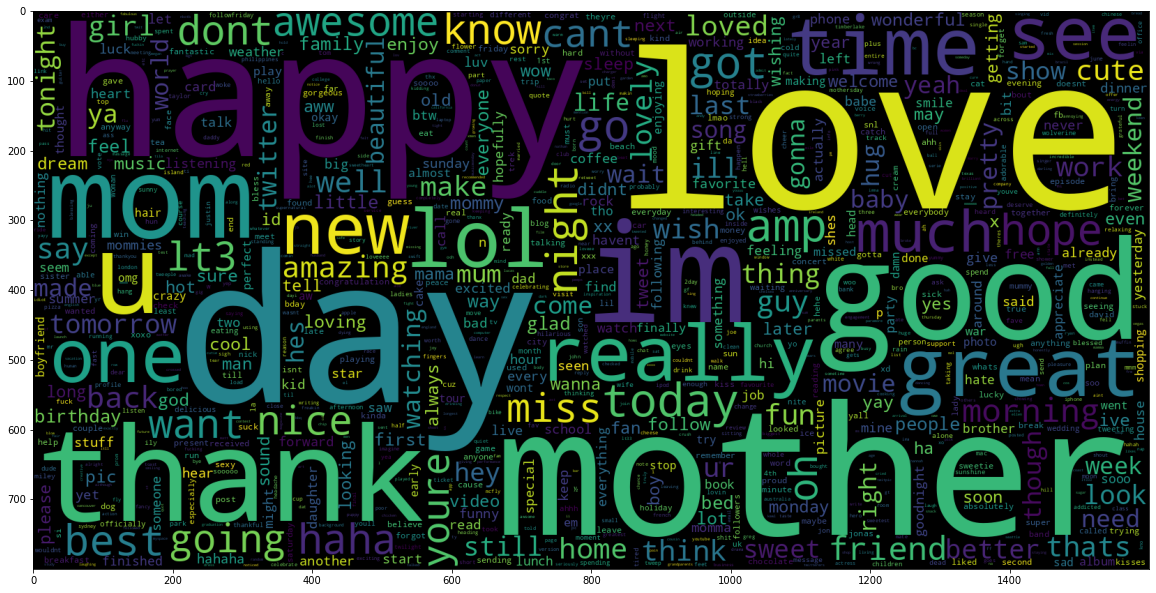

In [ ]:
data_test = data_preprocessed['content'][:40000]
df_sadness = data_preprocessed[data_preprocessed['sentiment'] == "sadness"]
df_hate = data_preprocessed[data_preprocessed['sentiment']=='hate']
df_worry = data_preprocessed[data_preprocessed['sentiment']=='worry']
df_love = data_preprocessed[data_preprocessed['sentiment']=='love']
data_sadness = df_sadness['content'][:10000]
data_hate = df_hate['content'][:10000]
data_worry = df_worry['content'][:10000]
data_love = df_love['content'][:10000]


plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
                collocations=False).generate(" ".join(data_love))
plt.imshow(wc)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e9a271ec-2e6a-48cd-95e1-869b203be896' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>